# FakeNewsNet Fake News Detection

In [5]:
!pip install pandas scikit-learn torch torchvision torchaudio transformers tqdm notebook
!pip install matplotlib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Data Preparation

In [6]:
import pandas as pd

base = "dataverse_files/dataset/"

# Load each domain-label CSV
politifact_real = pd.read_csv(base + "politifact_real.csv")
politifact_fake = pd.read_csv(base + "politifact_fake.csv")
gossipcop_real = pd.read_csv(base + "gossipcop_real.csv")
gossipcop_fake = pd.read_csv(base + "gossipcop_fake.csv")

# Add domain and label columns
politifact_real["domain"], politifact_real["label"] = "politifact", 1
politifact_fake["domain"], politifact_fake["label"] = "politifact", 0
gossipcop_real["domain"], gossipcop_real["label"] = "gossipcop", 1
gossipcop_fake["domain"], gossipcop_fake["label"] = "gossipcop", 0

# Combine all into one DataFrame
df = pd.concat([politifact_real, politifact_fake, gossipcop_real, gossipcop_fake], ignore_index=True)

# Keep only title + text columns (adjust if names differ)
text_cols = [c for c in df.columns if "title" in c.lower() or "text" in c.lower()]
df = df[text_cols + ["domain", "label"]]
df = df.dropna(subset=text_cols)

print("Combined dataset size:", len(df))
df.head()


Combined dataset size: 23196


,title,domain,label
0,National Federation of Independent Business,politifact,1
1,comments in Fayetteville NC,politifact,1
2,"Romney makes pitch, hoping to close deal : Ele...",politifact,1
3,Democratic Leaders Say House Democrats Are Uni...,politifact,1
4,"Budget of the United States Government, FY 2008",politifact,1


In [7]:
df = df.drop_duplicates()
print(df)
df["label"] = df["label"].astype(int)
df.to_csv("fakenewsnet_combined.csv", index=False)
print("Saved cleaned combined dataset as fakenewsnet_combined.csv")


                                                   title      domain  label
0            National Federation of Independent Business  politifact      1
1                            comments in Fayetteville NC  politifact      1
2      Romney makes pitch, hoping to close deal : Ele...  politifact      1
3      Democratic Leaders Say House Democrats Are Uni...  politifact      1
4        Budget of the United States Government, FY 2008  politifact      1
...                                                  ...         ...    ...
23191   September 11: Celebrities Remember 9/11 (TWEETS)   gossipcop      0
23192  NASCAR owners threaten to fire drivers who pro...   gossipcop      0
23193  The 7 signs that David Beckham is definitely h...   gossipcop      0
23194  Ryan Gosling and Eva Mendes Did Not Get Marrie...   gossipcop      0
23195  Jamie Foxx Spends the Day With Katie Holmes an...   gossipcop      0

[21848 rows x 3 columns]
Saved cleaned combined dataset as fakenewsnet_combined.csv


In [8]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.3, stratify=df[["domain","label"]], random_state=42)
val, test = train_test_split(temp, test_size=0.67, stratify=temp[["domain","label"]], random_state=42)

print("Train:", len(train), "Val:", len(val), "Test:", len(test))


Train: 15293 Val: 2163 Test: 4392


## 2. Baseline Model: TF-IDF + Logistic Regression

### Model implementation + Evaluation


Trying params: {'ngram_range': (1, 2), 'C': 1.0}
Val macro-F1: 0.7275210486031382

Trying params: {'ngram_range': (1, 2), 'C': 2.0}
Val macro-F1: 0.7327778740445523

Trying params: {'ngram_range': (1, 3), 'C': 1.0}
Val macro-F1: 0.7250268457493327

Trying params: {'ngram_range': (1, 3), 'C': 2.0}
Val macro-F1: 0.7256568739937327

Best params: {'ngram_range': (1, 2), 'C': 2.0}
Best val macro-F1: 0.7327778740445523
=== TF-IDF Test Classification Report ===
              precision    recall  f1-score   support

           0      0.592     0.722     0.651      1070
           1      0.904     0.840     0.870      3322

    accuracy                          0.811      4392
   macro avg      0.748     0.781     0.761      4392
weighted avg      0.828     0.811     0.817      4392



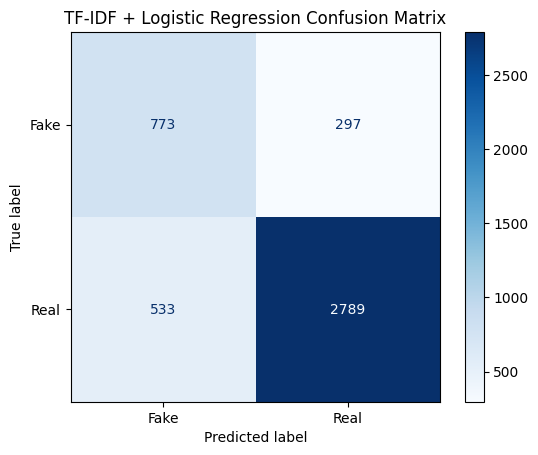


Top words predicting REAL news:
['season' 'best' 'awards' 'beauty' 'transcript' 'reveals' 'shares'
 'celebrates' 'birthday' 'bell' 'cardi' 'bachelorette' 'bachelor'
 'perfect' 'style']

Top words predicting FAKE news:
['breaking' 'trump' 'caitlyn' 'kanye' 'react' 'report' 'brad' 'beyonce'
 'pattinson' 'jenner' 'jennifer' 'angelina' 'pitt' 'politifact' 'rihanna']


In [9]:
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# -----------------------------
# 1. Text preprocessing
# -----------------------------
def clean_text(text):
    """
    Clean and normalize news text:
    - remove URLs, mentions, special chars
    - lowercase all text
    """
    text = re.sub(r"http\S+", "", text)             # remove URLs
    text = re.sub(r"@\w+", "", text)                # remove mentions
    text = re.sub(r"[^A-Za-z0-9\s']", " ", text)    # keep alphanumeric and spaces
    text = re.sub(r"\s+", " ", text)                # normalize whitespace
    return text.strip().lower()

from sklearn.metrics import f1_score

def make_xy(df):
    # combine first two columns as text
    X = (df.iloc[:, 0].fillna("") + " " + df.iloc[:, 1].fillna("")).apply(clean_text)
    y = df["label"]
    return X, y

X_train, y_train = make_xy(train)
X_val,   y_val   = make_xy(val)
X_test,  y_test  = make_xy(test)


# --------------------------------
# 2. Hyperparameter search on val
# --------------------------------
param_grid = [
    {"ngram_range": (1, 2), "C": 1.0},
    {"ngram_range": (1, 2), "C": 2.0},
    {"ngram_range": (1, 3), "C": 1.0},
    {"ngram_range": (1, 3), "C": 2.0},
]

best_macro_f1 = 0.0
best_params = None
best_tfidf = None
best_clf = None

for params in param_grid:
    print("\nTrying params:", params)

    tfidf_tmp = TfidfVectorizer(
        ngram_range=params["ngram_range"],
        min_df=3,
        max_df=0.9,
        max_features=100000,
        sublinear_tf=True,
        stop_words="english",
    )

    X_train_vec = tfidf_tmp.fit_transform(X_train)
    X_val_vec   = tfidf_tmp.transform(X_val)

    clf_tmp = LogisticRegression(
        C=params["C"],
        max_iter=300,
        class_weight="balanced",
        solver="liblinear",
    )

    clf_tmp.fit(X_train_vec, y_train)
    val_pred = clf_tmp.predict(X_val_vec)
    macro_f1 = f1_score(y_val, val_pred, average="macro")

    print("Val macro-F1:", macro_f1)

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_params = params
        best_tfidf = tfidf_tmp
        best_clf = clf_tmp

print("\nBest params:", best_params)
print("Best val macro-F1:", best_macro_f1)

# --------------------------------
# 3. Retrain on train + val with best params
# --------------------------------
train_full = pd.concat([train, val], ignore_index=True)
X_train_full, y_train_full = make_xy(train_full)

tfidf = TfidfVectorizer(      # use best params found on val
    ngram_range=best_params["ngram_range"],
    min_df=3,
    max_df=0.9,
    max_features=100000,
    sublinear_tf=True,
    stop_words="english",
)

X_train_full_vec = tfidf.fit_transform(X_train_full)
X_test_vec       = tfidf.transform(X_test)

clf = LogisticRegression(
    C=best_params["C"],
    max_iter=300,
    class_weight="balanced",
    solver="liblinear",
)

clf.fit(X_train_full_vec, y_train_full)
pred = clf.predict(X_test_vec)   # this is test prediction

# -----------------------------
# 4. Evaluation
# -----------------------------
print("=== TF-IDF Test Classification Report ===")
print(classification_report(y_test, pred, digits=3))

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("TF-IDF + Logistic Regression Confusion Matrix")
plt.show()

# -----------------------------
# 5. Feature Importance (Top Words)
# -----------------------------
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_real = np.argsort(coefs)[-15:]
top_fake = np.argsort(coefs)[:15]

print("\nTop words predicting REAL news:")
print(feature_names[top_real][::-1])

print("\nTop words predicting FAKE news:")
print(feature_names[top_fake])


## 3. Advanced Model: DistilBERT Transformer

### Model Implementation

In [10]:
!python -m pip install accelerate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import accelerate
from accelerate import Accelerator as HFAccelerator
import transformers.trainer as trainer_mod

class PatchedAccelerator(HFAccelerator):
    def __init__(self, *args, dispatch_batches=None, split_batches=None, **kwargs):
        # ignore the new args and just call the original Accelerator
        super().__init__(*args, **kwargs)

# make Trainer use our patched class
trainer_mod.Accelerator = PatchedAccelerator



c:\Users\AnZzzz\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
!python -m pip install --upgrade "transformers[torch]" accelerate datasets


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Title + Body

In [13]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset
import torch

# --- 1. Prepare text and labels ---
def prepare_text(df):
    # Combine first two columns as input text
    df["text"] = (df.iloc[:, 0].fillna("") + " " + df.iloc[:, 1].fillna("")).str.strip()
    df = df[["text", "label"]].copy()
    # Trainer expects the label column to be named "labels"
    df = df.rename(columns={"label": "labels"})
    return df

train_df = prepare_text(train.copy())
val_df   = prepare_text(val.copy())
test_df  = prepare_text(test.copy())   # kept for later evaluation

# --- 2. Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    # Tokenize text with truncation and fixed max length
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128,   # shorter sequence length for faster training
    )

# --- 3. Convert to Hugging Face Datasets ---
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# Remove raw text column after tokenization
train_ds = train_ds.remove_columns(["text"])
val_ds   = val_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

# Set torch format
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# --- 4. Load model ---
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
)

# Increase dropout to reduce overfitting
model.config.dropout = 0.3
model.config.attention_dropout = 0.3

# --- 5. Metrics function for training logs ---
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    # F1 for the positive class (label 1) in this binary task
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# --- 6. Training arguments ---
use_fp16 = torch.cuda.is_available()

args = TrainingArguments(
    output_dir="./models/distilbert_fakenews",
    eval_strategy="epoch",             # evaluate once per epoch
    save_strategy="epoch",             # save a checkpoint each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,                # small number + early stopping
    weight_decay=0.1,                  # stronger regularization
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,       # restore the best checkpoint
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,                # keep only the best checkpoint
    fp16=use_fp16,                     # use mixed precision on GPU
)

# --- 7. Trainer setup and training ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()

Map: 100%|██████████| 4392/4392 [00:00<00:00, 31842.59 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\AnZzzz\AppData\Local\Temp\ipykernel_22396\19927277.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.368600,0.386300,0.832178,0.893015
2,0.287100,0.395028,0.843273,0.898473


TrainOutput(global_step=1912, training_loss=0.35228990037072155, metrics={'train_runtime': 114.1843, 'train_samples_per_second': 267.865, 'train_steps_per_second': 16.745, 'total_flos': 1012911963823104.0, 'train_loss': 0.35228990037072155, 'epoch': 2.0})

Evaluation

=== BERT Test Classification Report ===
              precision    recall  f1-score   support

           0      0.755     0.592     0.664      1070
           1      0.877     0.938     0.907      3322

    accuracy                          0.854      4392
   macro avg      0.816     0.765     0.785      4392
weighted avg      0.847     0.854     0.847      4392

Macro-F1: 0.7850768876156606


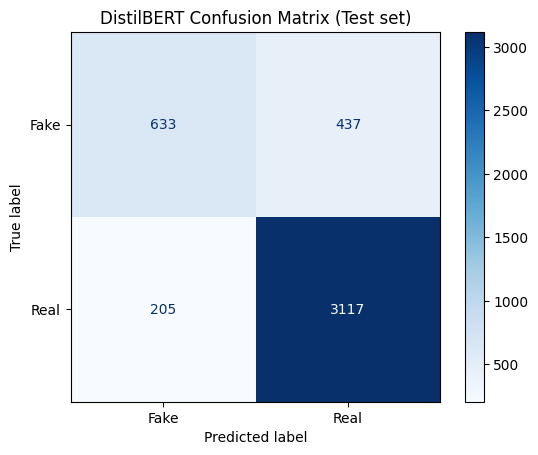

In [14]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
test_results = trainer.predict(test_ds)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

print("=== BERT Test Classification Report ===")
print(classification_report(test_labels, test_preds, digits=3))

# Macro-F1 explicitly
macro_f1 = f1_score(test_labels, test_preds, average="macro")
print("Macro-F1:", macro_f1)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("DistilBERT Confusion Matrix (Test set)")
plt.show()

Title Only

In [15]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, f1_score

# --- 1. Prepare text and labels (TITLE ONLY) ---
def prepare_text_title_only(df):
    # only use the first column (title) as input text
    df["text"] = df.iloc[:, 0].fillna("").astype(str).str.strip()
    df = df[["text", "label"]].copy()
    # Trainer expects the label column to be named "labels"
    df = df.rename(columns={"label": "labels"})
    return df

# make title-only versions of train / val / test
train_df = prepare_text_title_only(train.copy())
val_df   = prepare_text_title_only(val.copy())
test_df  = prepare_text_title_only(test.copy())   # kept for later evaluation

# --- 2. Load tokenizer ---
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    # Tokenize text with truncation and fixed max length
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128,   # shorter sequence length for faster training
    )

# --- 3. Convert to Hugging Face Datasets ---
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)
test_ds  = test_ds.map(tokenize_fn, batched=True)

# Remove raw text column after tokenization
train_ds = train_ds.remove_columns(["text"])
val_ds   = val_ds.remove_columns(["text"])
test_ds  = test_ds.remove_columns(["text"])

# Set torch format
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# --- 4. Load model ---
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
)

# Increase dropout to reduce overfitting
model.config.dropout = 0.3
model.config.attention_dropout = 0.3

# --- 5. Metrics function for training logs ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels, preds)
    # F1 for the positive class (label 1) in this binary task
    f1 = f1_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# --- 6. Training arguments ---
use_fp16 = torch.cuda.is_available()

args = TrainingArguments(
    output_dir="./models/distilbert_fakenews_title_only",  # 改一个输出目录名
    eval_strategy="epoch",             
    save_strategy="epoch",             
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.1,
    logging_dir="./logs_title_only",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    fp16=use_fp16,
)

# --- 7. Trainer setup and training ---
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)],
)

trainer.train()


Map: 100%|██████████| 4392/4392 [00:00<00:00, 26866.25 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\AnZzzz\AppData\Local\Temp\ipykernel_22396\2429014864.py:98: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.364500,0.391562,0.837263,0.896104
2,0.274800,0.403645,0.834951,0.893146


TrainOutput(global_step=1912, training_loss=0.34863846571375634, metrics={'train_runtime': 125.0218, 'train_samples_per_second': 244.645, 'train_steps_per_second': 15.293, 'total_flos': 1012911963823104.0, 'train_loss': 0.34863846571375634, 'epoch': 2.0})

### Evaluation

=== BERT Title-only Test Classification Report ===
              precision    recall  f1-score   support

           0      0.760     0.586     0.662      1070
           1      0.876     0.940     0.907      3322

    accuracy                          0.854      4392
   macro avg      0.818     0.763     0.784      4392
weighted avg      0.848     0.854     0.847      4392

Macro-F1 (title-only): 0.784347269230784


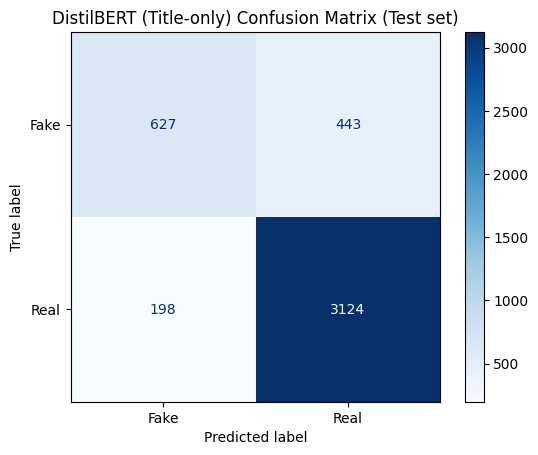

In [16]:
# Evaluation for BERT (title-only)
from sklearn.metrics import (
    classification_report,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import numpy as np
import matplotlib.pyplot as plt

test_results_title = trainer.predict(test_ds)
y_pred_title = np.argmax(test_results_title.predictions, axis=1)
y_true_title = test_results_title.label_ids

print("=== BERT Title-only Test Classification Report ===")
print(classification_report(y_true_title, y_pred_title, digits=3))

# Macro-F1
macro_f1_title = f1_score(y_true_title, y_pred_title, average="macro")
print("Macro-F1 (title-only):", macro_f1_title)

# Confusion matrix
cm_title = confusion_matrix(y_true_title, y_pred_title)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_title,
    display_labels=["Fake", "Real"]
)
disp.plot(cmap="Blues")
plt.title("DistilBERT (Title-only) Confusion Matrix (Test set)")
plt.show()

## 4. Cross-Domain Evaluation

In [17]:
df["text"] = df["title"].astype(str).apply(clean_text)
pf = df[df["domain"] == "politifact"].reset_index(drop=True)
gc = df[df["domain"] == "gossipcop"].reset_index(drop=True)

print(len(pf), "PolitiFact samples")
print(len(gc), "GossipCop samples")

985 PolitiFact samples
20863 GossipCop samples


### TF-IDF Cross-Domain

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

# Train on PF, test on GC
X_train = pf["text"]
y_train = pf["label"]

X_test = gc["text"]
y_test = gc["label"]

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    stop_words="english"
)

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec  = tfidf.transform(X_test)

clf = LogisticRegression(
    C=2,
    max_iter=300,
    class_weight="balanced",
    solver="liblinear"
)
clf.fit(X_train_vec, y_train)

pred = clf.predict(X_test_vec)

print("=== TF-IDF Cross-Domain: Train PF → Test GC ===")
print(classification_report(y_test, pred, digits=3))

macro_f1_pf_gc = f1_score(y_test, pred, average="macro")
print("Macro-F1:", macro_f1_pf_gc)


=== TF-IDF Cross-Domain: Train PF → Test GC ===
              precision    recall  f1-score   support

           0      0.199     0.226     0.211      4896
           1      0.752     0.721     0.736     15967

    accuracy                          0.605     20863
   macro avg      0.476     0.473     0.474     20863
weighted avg      0.622     0.605     0.613     20863

Macro-F1: 0.47392027723598495


### BERT Cross-Domain

#### Dataset Preparation and Tokenization

In [19]:
pf_ds = Dataset.from_pandas(pf[["text", "label"]])
gc_ds = Dataset.from_pandas(gc[["text", "label"]])

pf_tok = pf_ds.map(tokenize_fn, batched=True)
gc_tok = gc_ds.map(tokenize_fn, batched=True)

pf_tok = pf_tok.rename_column("label", "labels")
gc_tok = gc_tok.rename_column("label", "labels")

pf_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
gc_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map: 100%|██████████| 20863/20863 [00:00<00:00, 25565.42 examples/s]


#### Train on PolitiFact, Test on GossipCop

In [20]:
model_pf = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

args_pf = TrainingArguments(
    output_dir="./bert_pf",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="no",
)

trainer_pf = Trainer(
    model=model_pf,
    args=args_pf,
    train_dataset=pf_tok,
    tokenizer=tokenizer
)

trainer_pf.train()

gc_pred = trainer_pf.predict(gc_tok)
gc_preds = np.argmax(gc_pred.predictions, axis=1)
gc_labels = gc_pred.label_ids

print("=== BERT Cross-Domain: Train PF → Test GC ===")
print(classification_report(gc_labels, gc_preds, digits=3))
print("Macro-F1:", f1_score(gc_labels, gc_preds, average="macro"))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\AnZzzz\AppData\Local\Temp\ipykernel_22396\2905287706.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pf = Trainer(


Step,Training Loss


=== BERT Cross-Domain: Train PF → Test GC ===
              precision    recall  f1-score   support

           0      0.242     0.793     0.370      4896
           1      0.788     0.236     0.363     15967

    accuracy                          0.367     20863
   macro avg      0.515     0.515     0.367     20863
weighted avg      0.660     0.367     0.365     20863

Macro-F1: 0.3668989367079301


#### Train on GossipCop, Test on PolitiFact

In [21]:
model_gc = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

args_gc = TrainingArguments(
    output_dir="./bert_gc",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="no",
)

trainer_gc = Trainer(
    model=model_gc,
    args=args_gc,
    train_dataset=gc_tok,
    tokenizer=tokenizer
)

trainer_gc.train()

pf_pred = trainer_gc.predict(pf_tok)
pf_preds = np.argmax(pf_pred.predictions, axis=1)
pf_labels = pf_pred.label_ids

print("=== BERT Cross-Domain: Train GC → Test PF ===")
print(classification_report(pf_labels, pf_preds, digits=3))
print("Macro-F1:", f1_score(pf_labels, pf_preds, average="macro"))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\AnZzzz\AppData\Local\Temp\ipykernel_22396\2377643523.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_gc = Trainer(


Step,Training Loss
500,0.471700
1000,0.410300
1500,0.391800
2000,0.382000
2500,0.364900
3000,0.329800
3500,0.306200
4000,0.295600
4500,0.311700
5000,0.301100


=== BERT Cross-Domain: Train GC → Test PF ===
              precision    recall  f1-score   support

           0      0.455     0.442     0.448       428
           1      0.581     0.594     0.587       557

    accuracy                          0.528       985
   macro avg      0.518     0.518     0.518       985
weighted avg      0.526     0.528     0.527       985

Macro-F1: 0.5178993769873723


### Failure Analysis

In [22]:
import pandas as pd
import numpy as np

# get BERT predictions again
test_result = trainer.predict(test_ds)
test_preds = np.argmax(test_result.predictions, axis=1)

# copy test set (with text + label)
fail_df = test_df.copy()
fail_df["pred"] = test_preds

# wrong cases
wrong_df = fail_df[fail_df["labels"] != fail_df["pred"]]

print("Total wrong predictions:", len(wrong_df))
wrong_df.head(5)

Total wrong predictions: 641


,text,labels,pred
19215,Kanye West’s new album The Life of Pablo: A tr...,0,1
20017,Be Very Afraid,0,1
20980,Mariah Carey Launched “Tea”-Themed Merch from ...,0,1
20591,Kim Kardashian & Kanye West Named Their Daught...,0,1
5508,"Heidi Klum, 44, confirms split from Vito Schna...",1,0


In [23]:
# real news predicted as fake
real_to_fake = fail_df[(fail_df["labels"] == 1) & (fail_df["pred"] == 0)]

print("Real → Fake (first 5 samples)")
real_to_fake[["text", "labels", "pred"]].head(5)

Real → Fake (first 5 samples)


,text,labels,pred
5508,"Heidi Klum, 44, confirms split from Vito Schna...",1,0
16189,Who Knows Kelly Ripa Better: Andy Cohen or Rya...,1,0
6171,Kim Kardashian auctioning off clothes to benef...,1,0
5663,Kylie Jenner And Travis Scott Spotted Together...,1,0
12368,Nicole Kidman reveals creepy secret: 'I eat bugs',1,0


In [24]:
# fake news predicted as real
fake_to_real = fail_df[(fail_df["labels"] == 0) & (fail_df["pred"] == 1)]

print("Fake → Real (first 5 samples)")
fake_to_real[["text", "labels", "pred"]].head(5)

Fake → Real (first 5 samples)


,text,labels,pred
19215,Kanye West’s new album The Life of Pablo: A tr...,0,1
20017,Be Very Afraid,0,1
20980,Mariah Carey Launched “Tea”-Themed Merch from ...,0,1
20591,Kim Kardashian & Kanye West Named Their Daught...,0,1
22165,Keeping Up with the Kardashians,0,1


### E5 – Out-of-time evaluation on newly collected 2025 news

In [25]:
import pandas as pd

e5_path = "E5_extended_news_21.csv"  # 放在和 notebook 同一目录的话这样就行
e5_raw = pd.read_csv(e5_path)

e5_raw.head()

,title,text,label,date
0,U.N. Peacekeepers Begin Withdrawal From Northe...,U.N. peacekeeping forces began a phased withdr...,1,2025-11-30
1,Global Markets Rally as Fed Signals Possible R...,Global stock markets surged after the U.S. Fed...,1,2025-12-02
2,California Reports Record Low Wildfire Activit...,California fire officials confirmed that the 2...,1,2025-11-29
3,WHO Declares End of Yellow Fever Outbreak in W...,The WHO announced the end of the yellow fever ...,1,2025-12-01
4,Scientists Detect Rare Comet Passing Near Eart...,Astronomers detected a rare comet passing thro...,1,2025-12-03


In [26]:
def make_xy(df):
    # first two columns are title and text
    X = (df.iloc[:, 0].fillna("") + " " + df.iloc[:, 1].fillna("")).apply(clean_text)
    y = df["label"]
    return X, y

# make sure label is int
e5_raw["label"] = e5_raw["label"].astype(int)

# keep columns order: title, text, label
e5_df = e5_raw[["title", "text", "label"]].copy()
e5_df.head()

,title,text,label
0,U.N. Peacekeepers Begin Withdrawal From Northe...,U.N. peacekeeping forces began a phased withdr...,1
1,Global Markets Rally as Fed Signals Possible R...,Global stock markets surged after the U.S. Fed...,1
2,California Reports Record Low Wildfire Activit...,California fire officials confirmed that the 2...,1
3,WHO Declares End of Yellow Fever Outbreak in W...,The WHO announced the end of the yellow fever ...,1
4,Scientists Detect Rare Comet Passing Near Eart...,Astronomers detected a rare comet passing thro...,1


TF-IDF + LR (Out-of-time)

=== TF-IDF + LR on new 2025 news ===
              precision    recall  f1-score   support

           0      0.692     0.818     0.750        11
           1      0.750     0.600     0.667        10

    accuracy                          0.714        21
   macro avg      0.721     0.709     0.708        21
weighted avg      0.720     0.714     0.710        21



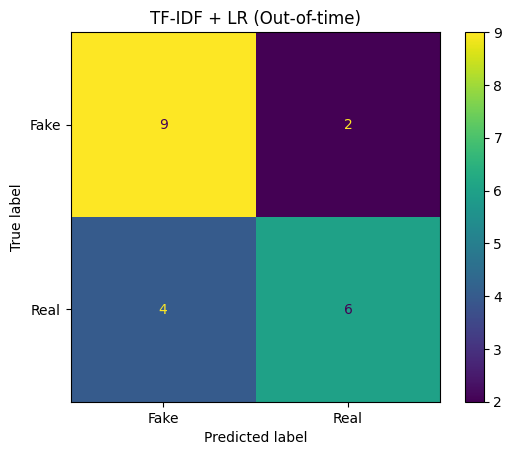

In [28]:
# X_e5, y_e5 for LR baseline
X_e5, y_e5 = make_xy(e5_df)

# transform by the same tfidf as E1 baseline
X_e5_vec = tfidf.transform(X_e5)

# predict
e5_pred_lr = clf.predict(X_e5_vec)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("=== TF-IDF + LR on new 2025 news ===")
print(classification_report(y_e5, e5_pred_lr, digits=3))

cm_lr = confusion_matrix(y_e5, e5_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Fake", "Real"])
disp_lr.plot()
plt.title("TF-IDF + LR (Out-of-time)")
plt.show()

DistilBERT (Out-of-time)

In [29]:
from datasets import Dataset
import numpy as np

def prepare_e5_for_bert(df):
    df = df.copy()
    # combine title + text into one field "text"
    df["text"] = (df["title"].fillna("") + " " + df["text"].fillna("")).str.strip()
    df = df[["text", "label"]].rename(columns={"label": "labels"})
    return df

e5_for_bert = prepare_e5_for_bert(e5_raw)

# build Huggingface Dataset
e5_dataset = Dataset.from_pandas(e5_for_bert)

# use your existing tokenize_fn
e5_tok = e5_dataset.map(tokenize_fn, batched=True)
e5_tok = e5_tok.remove_columns(["text"])
e5_tok.set_format("torch")

Map: 100%|██████████| 21/21 [00:00<00:00, 6999.95 examples/s]


=== E5 – DistilBERT (title+body) on new 2025 news ===
              precision    recall  f1-score   support

           0      1.000     0.455     0.625        11
           1      0.625     1.000     0.769        10

    accuracy                          0.714        21
   macro avg      0.812     0.727     0.697        21
weighted avg      0.821     0.714     0.694        21



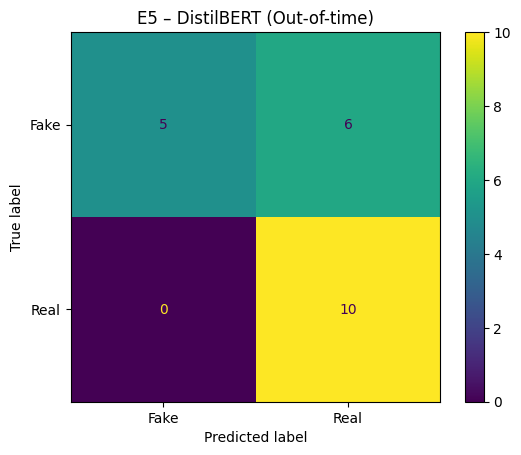

In [ ]:
e5_result = trainer.predict(e5_tok)
e5_logits = e5_result.predictions
e5_labels = e5_result.label_ids

e5_pred_bert = np.argmax(e5_logits, axis=1)

print("=== DistilBERT (title+body) on new 2025 news ===")
print(classification_report(e5_labels, e5_pred_bert, digits=3))

cm_bert = confusion_matrix(e5_labels, e5_pred_bert)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["Fake", "Real"])
disp_bert.plot()
plt.title("DistilBERT (Out-of-time)")
plt.show()